# **INFO5731 Assignment 5**

---


**This exercise aims to provide a comprehensive learning experience in text analysis and machine learning techniques, focusing on both text classification and clustering tasks.**

***Please use the text corpus you collected in your last in-class-exercise for this exercise. Perform the following tasks***.

**Expectations**:
*   Students are expected to complete the exercise during lecture period to meet the active participation criteria of the course.
*   Use the provided .*ipynb* document to write your code & respond to the questions. Avoid generating a new file.
*   Write complete answers and run all the cells before submission.
*   Make sure the submission is "clean"; *i.e.*, no unnecessary code cells.
*   Once finished, allow shared rights from top right corner (*see Canvas for details*).

**Total points**: 100

**Full Points will be given those who present well**

**Late submissions will have a penalty of 10% of the marks for each day of late submission, and no requests will be answered. Manage your time accordingly.**


# **Question 1 (20 Points)**

# **SENTIMENT ANALYSIS**

The objective of this assignment is to give you **hands-on experience** in applying various** sentiment analysis techniques** on real-world textual data. You are expected to explore data, apply machine learning models, and evaluate their performance

**1. Dataset Collection & Preparation**

Find a real-world dataset with text and positive, negative, and neutral sentiment labels.

Justify your dataset choice and handle **class imbalance** if needed.

**2. Exploratory Data Analysis (EDA)**

Clean and preprocess the data (tokenization, stopwords, lemmatization).

Perform EDA: class distribution, word clouds, n-gram analysis, sentence lengths, etc.

Visualize insights using relevant plots and charts.

**3. Sentiment Classification**

Apply at least three traditional ML models (e.g., SVM, Naive Bayes, XGBoost) using TF-IDF or embeddings.

If applicable, compare with a pretrained model (RoBERTa/BERT).

Tune hyperparameters and use cross-validation.

**4. Evaluation & Reporting**

Evaluate with metrics: Accuracy, Precision, Recall, F1, Confusion Matrix.

Summarize results, compare models, and reflect on what worked.

In [68]:
#importing data libraries
import re
import kagglehub
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import string

from sklearn.utils import resample
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer,ENGLISH_STOP_WORDS
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from IPython.display import display
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from wordcloud import WordCloud
from collections import Counter
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split, cross_val_score

In [69]:
# downloading the dataset
path = kagglehub.dataset_download("crowdflower/twitter-airline-sentiment")

# listing files in the path to confirm CSV filename
print("Files in dataset path:", os.listdir(path))

# loading correct CSV file
csv_path = os.path.join(path, 'Tweets.csv')
df = pd.read_csv(csv_path)

# displaying some basic info
print(df.shape)
print(df.columns)
print(df[['text', 'airline_sentiment']].head())

Files in dataset path: ['Tweets.csv', 'database.sqlite']
(14640, 15)
Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'],
      dtype='object')
                                                text airline_sentiment
0                @VirginAmerica What @dhepburn said.           neutral
1  @VirginAmerica plus you've added commercials t...          positive
2  @VirginAmerica I didn't today... Must mean I n...           neutral
3  @VirginAmerica it's really aggressive to blast...          negative
4  @VirginAmerica and it's a really big bad thing...          negative


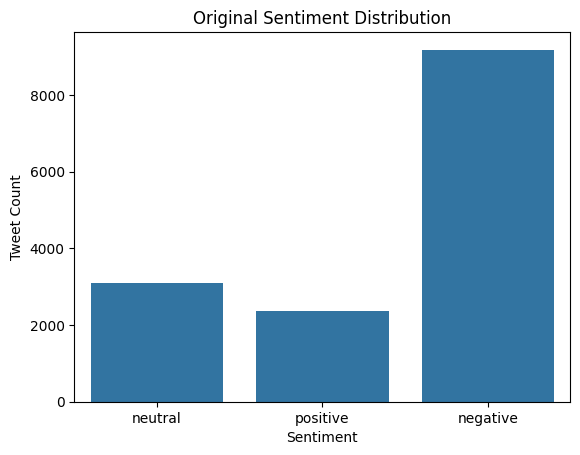

 Class Weights for Model Training: {np.int64(0): np.float64(0.5317062540858575), np.int64(1): np.float64(1.5747015166182639), np.int64(2): np.float64(2.0651713922979265)}


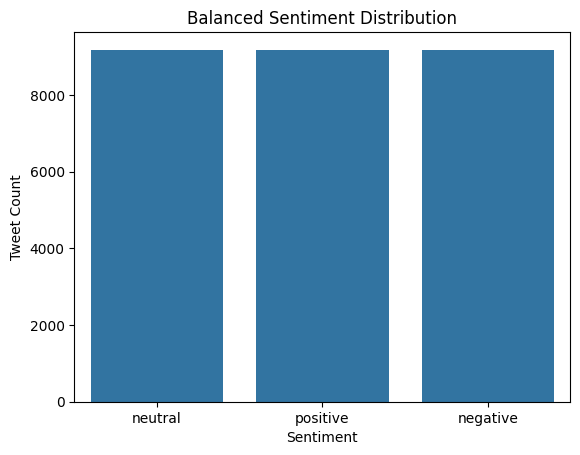

Balanced dataset shape: (27534, 16)
Preview:
                                                 text airline_sentiment
0  @united Hi! what is the phone number for reser...           neutral
1  @SouthwestAir   Happily, flight 1625 was not d...          positive
2  @SouthwestAir thanks! I expected a wait... Jus...          negative
3  @USAirways according to @wtop DCA seems to be ...          negative
4  @united Hi JH, my experience with United has b...          negative


In [70]:
# plotting sentiment distribution of the tweets
sns.countplot(data=df, x='airline_sentiment')
plt.title("Original Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Tweet Count")
plt.show()

# encoding labels for the model
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['airline_sentiment'])  # Convert sentiment labels to integers: negative=0, neutral=1, positive=2

# computing class weights
classes = np.array([0, 1, 2])  # defining all possible class labels as a np.array
class_weights = compute_class_weight(
    class_weight='balanced', # using 'balanced' mode to handle class imbalance
    classes=classes,
    y=df['label']
)
class_weights_dict = dict(zip(classes, class_weights))
print(" Class Weights for Model Training:", class_weights_dict)

# separating classes into positive, negative and neutral
df_neg = df[df['airline_sentiment'] == 'negative']
df_neu = df[df['airline_sentiment'] == 'neutral']
df_pos = df[df['airline_sentiment'] == 'positive']

# increasing minority classes
df_neu_up = resample(df_neu, replace=True, n_samples=len(df_neg), random_state=42)
df_pos_up = resample(df_pos, replace=True, n_samples=len(df_neg), random_state=42)

# combining into a balanced dataset
df_balanced = pd.concat([df_neg, df_neu_up, df_pos_up])

# introducing randomness by shuffling the dataset
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# illustrating the new balanced sentiment distribution
sns.countplot(data=df_balanced, x='airline_sentiment')
plt.title("Balanced Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Tweet Count")
plt.show()

# informing about size and sample rows from balanced dataset
print("Balanced dataset shape:", df_balanced.shape)
print("Preview:\n", df_balanced[['text', 'airline_sentiment']].head())


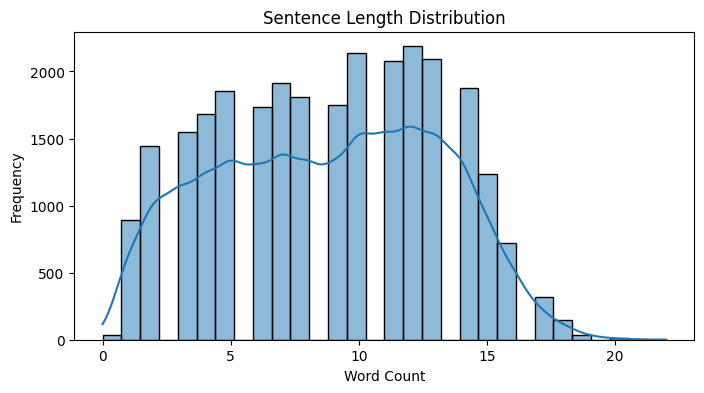

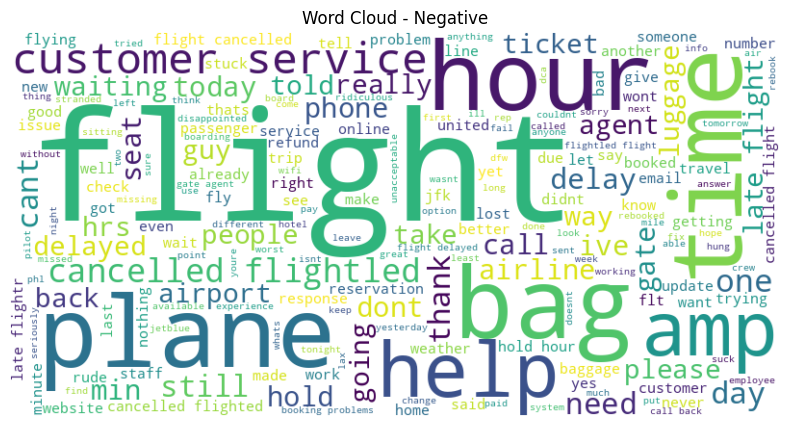

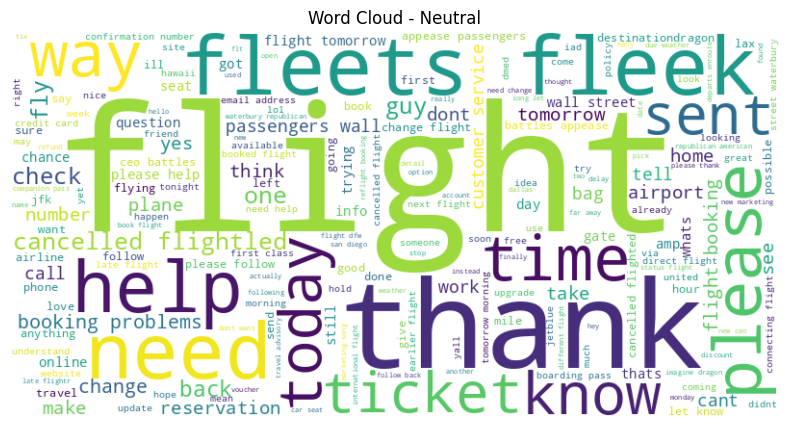

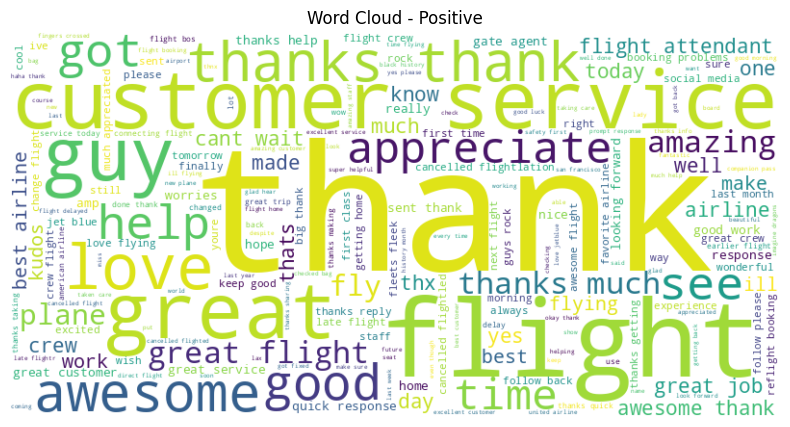

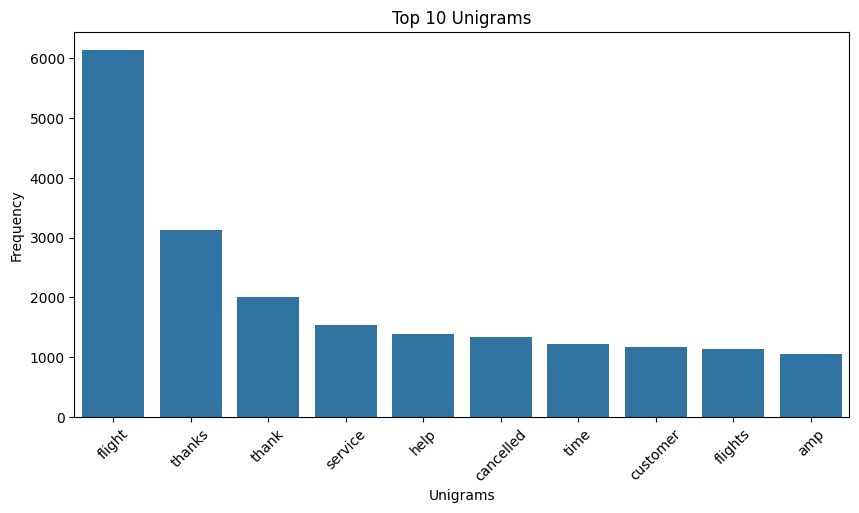

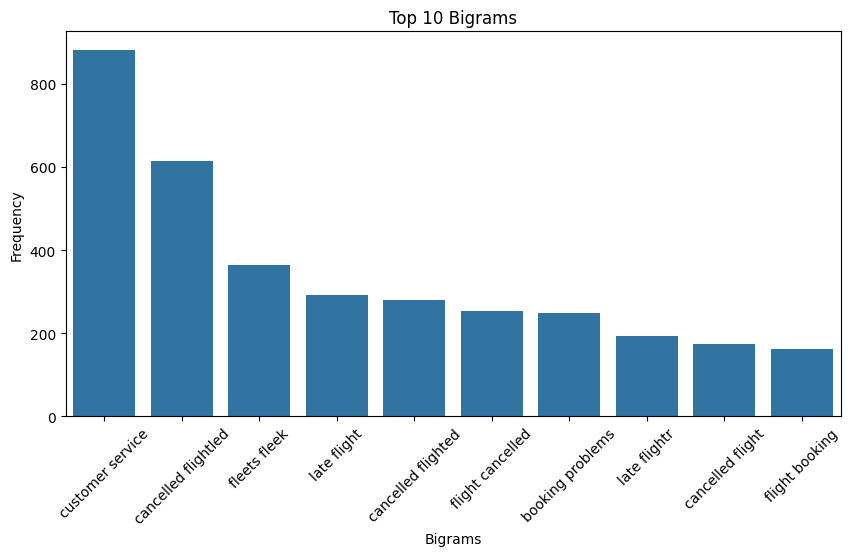

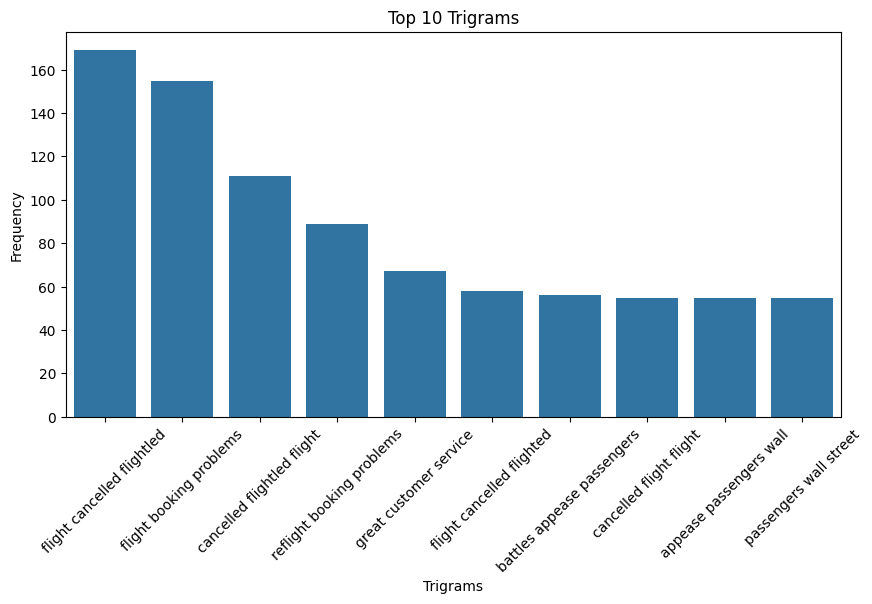

In [71]:
# initializing basic list of common stopwords to remove from tweets
basic_stopwords = set("""
a an the and or is are was were be to of in for on at with that this it
by from up down out over under again further then once here there when where why how
all any both each few more most other some such no nor not only own same so than too very
can will just don should now
""".split())

# defining a function for cleaning and preprocessing tweet text
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|@\S+|[^a-z\s]", "", text)  # remove URLs, mentions, symbols
    tokens = text.split()
    tokens = [word for word in tokens if word not in basic_stopwords and len(word) > 2]
    return ' '.join(tokens)

df_balanced['clean_text'] = df_balanced['text'].apply(clean_text)
df_balanced['text_len'] = df_balanced['clean_text'].apply(lambda x: len(x.split()))

# illustrating distribution of sentence lengths in the dataset
plt.figure(figsize=(8, 4))
sns.histplot(df_balanced['text_len'], bins=30, kde=True)
plt.title("Sentence Length Distribution")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.show()

# generating and displaying word clouds for each sentiment class
for sentiment in ['negative', 'neutral', 'positive']:
    wc = WordCloud(width=800, height=400, background_color='white').generate(
        ' '.join(df_balanced[df_balanced['airline_sentiment'] == sentiment]['clean_text'])
    )
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud - {sentiment.capitalize()}")
    plt.show()

# defining a function to extract and sort top N n-grams
def get_top_ngrams(corpus, ngram_range=(1,1), n=10):
    vec = CountVectorizer(ngram_range=ngram_range, stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    return sorted(words_freq, key=lambda x: x[1], reverse=True)[:n]

# extracting and visualizing unigrams, bigrams, and trigrams
for name, ngram_range in [('Unigrams', (1,1)), ('Bigrams', (2,2)), ('Trigrams', (3,3))]:
    top_ngrams = get_top_ngrams(df_balanced['clean_text'], ngram_range=ngram_range)
    ngrams_df = pd.DataFrame(top_ngrams, columns=[name, 'Frequency']) # creating a dataframe for plotting
    plt.figure(figsize=(10, 5))
    sns.barplot(data=ngrams_df, x=name, y='Frequency')
    plt.title(f"Top 10 {name}")
    plt.xticks(rotation=45)
    plt.show()

In [72]:
# making sure df_balanced is already defined
df_ml = df_balanced.copy()

# defining a basic stopword if not already defined
basic_stopwords = set([
    'the', 'and', 'to', 'of', 'in', 'a', 'is', 'it', 'you', 'that', 'on',
    'for', 'with', 'was', 'as', 'this', 'but', 'be', 'at', 'not', 'have'
])

# defining a function to clean tweet text
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|@\S+|[^a-z\s]", "", text)
    tokens = text.split()
    tokens = [word for word in tokens if word not in basic_stopwords and len(word) > 2]
    return ' '.join(tokens)

# cleaning and encoding sentiment labels for model training
df_ml['clean_text'] = df_ml['text'].apply(clean_text)
df_ml['label'] = df_ml['airline_sentiment'].map({'negative': 0, 'neutral': 1, 'positive': 2})

# splitting the data into training and testing sets
X = df_ml['clean_text']
y = df_ml['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# initializing a dictionary of different ML models to compare
models = {
    'Naive Bayes': MultinomialNB(),
    'SVM': LinearSVC(),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
}

results = {}

# iterating through each model for training and evaluation
for name, model in models.items():
    pipe = Pipeline([
        ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1, 2))),
        ('clf', model)
    ])

    print(f"\n Training {name} model...")
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    print(f"\n{name} Classification Report:")
    print(classification_report(y_test, y_pred, target_names=['negative', 'neutral', 'positive']))

    # conducting cross-validation to assess general performance
    scores = cross_val_score(pipe, X, y, cv=5, scoring='f1_weighted')
    print(f"{name} Cross-Validation F1 Score: {scores.mean():.4f}")
    results[name] = scores.mean()

# displaying results
results_df = pd.DataFrame(list(results.items()), columns=['Model', 'Cross-Val F1 Score'])
results_df = results_df.sort_values(by='Cross-Val F1 Score', ascending=False).reset_index(drop=True)

display(results_df)


 Training Naive Bayes model...

Naive Bayes Classification Report:
              precision    recall  f1-score   support

    negative       0.77      0.84      0.81      1828
     neutral       0.81      0.75      0.78      1879
    positive       0.85      0.83      0.84      1800

    accuracy                           0.81      5507
   macro avg       0.81      0.81      0.81      5507
weighted avg       0.81      0.81      0.81      5507

Naive Bayes Cross-Validation F1 Score: 0.8077

 Training SVM model...

SVM Classification Report:
              precision    recall  f1-score   support

    negative       0.88      0.81      0.84      1828
     neutral       0.85      0.88      0.87      1879
    positive       0.91      0.94      0.92      1800

    accuracy                           0.88      5507
   macro avg       0.88      0.88      0.88      5507
weighted avg       0.88      0.88      0.88      5507

SVM Cross-Validation F1 Score: 0.8768

 Training XGBoost model...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:44:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



XGBoost Classification Report:
              precision    recall  f1-score   support

    negative       0.89      0.77      0.83      1828
     neutral       0.76      0.89      0.82      1879
    positive       0.89      0.85      0.87      1800

    accuracy                           0.84      5507
   macro avg       0.85      0.84      0.84      5507
weighted avg       0.85      0.84      0.84      5507



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:45:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:45:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:46:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:46:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:46:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

XGBoost Cross-Validation F1 Score: 0.8390


,Model,Cross-Val F1 Score
0,SVM,0.876750
1,XGBoost,0.839006
2,Naive Bayes,0.807668



 Evaluating Naive Bayes...

Classification Report:
              precision    recall  f1-score   support

    negative       0.77      0.84      0.81      1828
     neutral       0.81      0.75      0.78      1879
    positive       0.85      0.83      0.84      1800

    accuracy                           0.81      5507
   macro avg       0.81      0.81      0.81      5507
weighted avg       0.81      0.81      0.81      5507

Confusion Matrix:


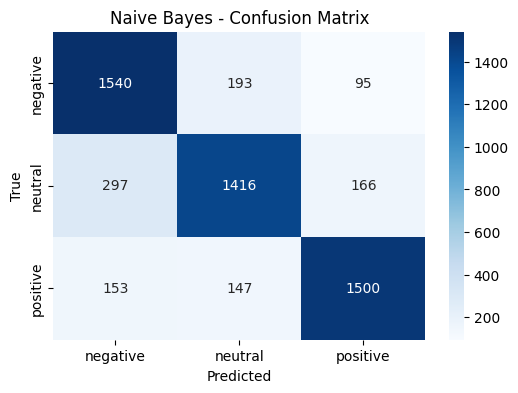


 Evaluating SVM...

Classification Report:
              precision    recall  f1-score   support

    negative       0.88      0.81      0.84      1828
     neutral       0.85      0.88      0.87      1879
    positive       0.91      0.94      0.92      1800

    accuracy                           0.88      5507
   macro avg       0.88      0.88      0.88      5507
weighted avg       0.88      0.88      0.88      5507

Confusion Matrix:


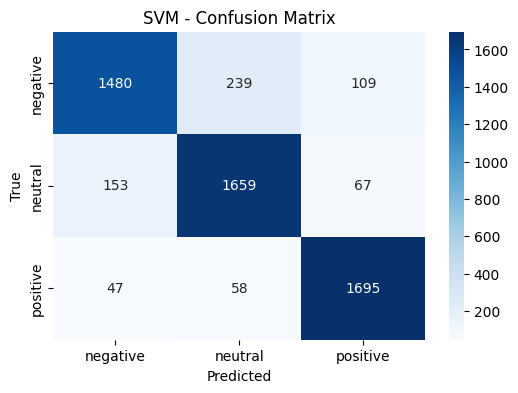


 Evaluating XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:47:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Classification Report:
              precision    recall  f1-score   support

    negative       0.89      0.77      0.83      1828
     neutral       0.76      0.89      0.82      1879
    positive       0.89      0.85      0.87      1800

    accuracy                           0.84      5507
   macro avg       0.85      0.84      0.84      5507
weighted avg       0.85      0.84      0.84      5507

Confusion Matrix:


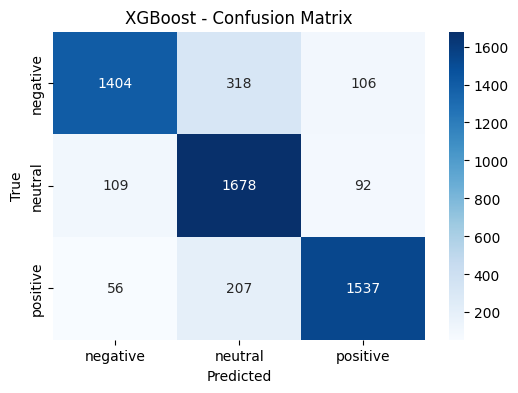


 Evaluation Summary:


,Model,Accuracy,Precision,Recall,F1 Score
0,SVM,0.877792,0.877928,0.877792,0.877129
1,XGBoost,0.838751,0.846479,0.838751,0.839136
2,Naive Bayes,0.809152,0.810430,0.809152,0.808970


In [73]:
# storing detailed evaluation metrics for each model
detailed_results = []

# iterating through each model for evaluation
for name, model in models.items():

  # creating a pipeline that vectorizes the text and fits the model
    pipe = Pipeline([
        ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1, 2))),
        ('clf', model) # inserting classifier into pipeline
    ])

    print(f"\n Evaluating {name}...") # indicating which model is being evaluated
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    # calculating evaluation metrics
    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    cm = confusion_matrix(y_test, y_pred)

    # printing classification report and confusion matrix
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['negative', 'neutral', 'positive']))
    print("Confusion Matrix:")
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=['negative', 'neutral', 'positive'], yticklabels=['negative', 'neutral', 'positive'])
    plt.title(f'{name} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # inserting all collected metrics into results list
    detailed_results.append({
        'Model': name,
        'Accuracy': acc,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    })

# converting metrics list into a df for better view
metrics_df = pd.DataFrame(detailed_results).sort_values(by='F1 Score', ascending=False).reset_index(drop=True)

# displaying the complete evaluation metrics summary
print("\n Evaluation Summary:")
display(metrics_df)

## **Question 2 (30 Points)**

# **Text Classification**

The purpose of the question is to practice different machine learning algorithms for **text classification** as well as the performance evaluation. In addition, you are requried to conduct **10 fold cross validation** (https://scikit-learn.org/stable/modules/cross_validation.html) in the training.



The dataset can be download from canvas. The dataset contains two files train data and test data for sentiment analysis in IMDB review, it has two categories: 1 represents positive and 0 represents negative. You need to split the training data into training and validate data (80% for training and 20% for validation, https://towardsdatascience.com/train-test-split-and-cross-validation-in-python-80b61beca4b6) and perform 10 fold cross validation while training the classifier. The final trained model was final evaluated on the test data.



1.   **Perform EDA on test and tran dataset**

2.   **Algorithms (Minimum 4):**

*   SVM
*   KNN
*   Decision tree
*   Random Forest
*   XGBoost
*   Word2Vec
*   BERT

3. **Evaluation measurement:**

*   Accuracy
*   Recall
*   Precison
*   F-1 score


In [74]:
# Write your code here

# loading data from a text file
def load_data(path):
    with open(path, 'r', encoding='utf-8') as f:
        lines = f.readlines()
    labels, texts = zip(*[(int(line[0]), line[2:].strip()) for line in lines])
    return pd.DataFrame({'label': labels, 'text': texts})

# loading training and testing datasets
train_df = load_data("stsa-train.txt")
test_df = load_data("stsa-test.txt")

# defining a basic text preprocessing function
def basic_preprocess(text):
    text = text.lower()
    text = "".join([c for c in text if c not in string.punctuation])
    tokens = text.split()
    tokens = [w for w in tokens if w not in ENGLISH_STOP_WORDS]
    return " ".join(tokens)

# applying preprocessing to training and testing text data
train_df['clean_text'] = train_df['text'].apply(basic_preprocess)
test_df['clean_text'] = test_df['text'].apply(basic_preprocess)

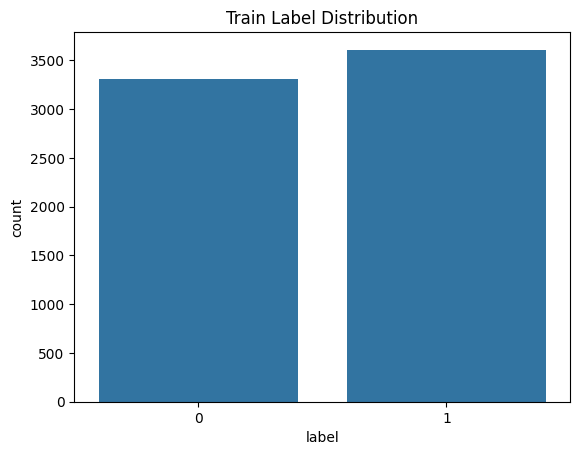

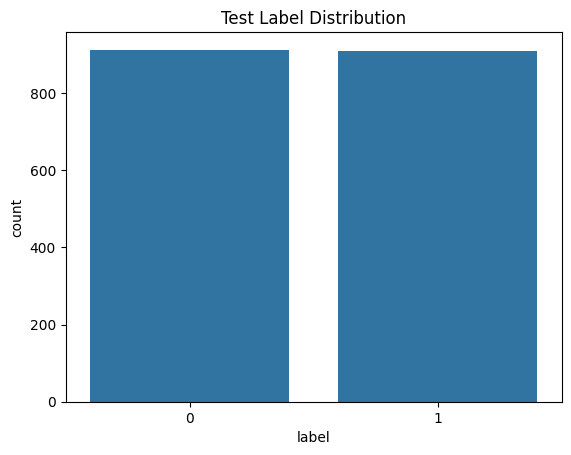

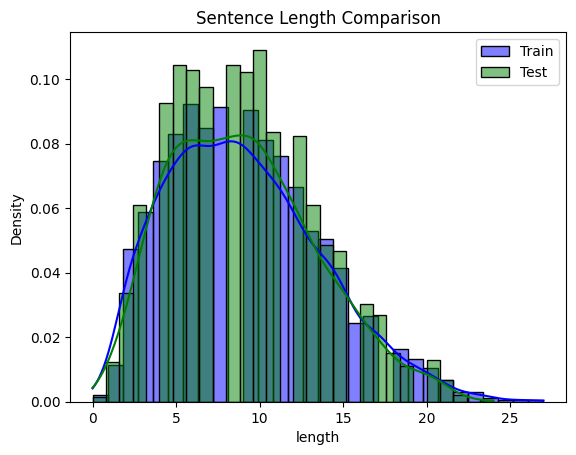

In [75]:
# plotting class distribution for training labels
sns.countplot(data=train_df, x='label')
plt.title("Train Label Distribution")
plt.show()

# plotting class distribution for test labels
sns.countplot(data=test_df, x='label')
plt.title("Test Label Distribution")
plt.show()

# calculating sentence lengths for train and test sets
train_df['length'] = train_df['clean_text'].apply(lambda x: len(x.split()))
test_df['length'] = test_df['clean_text'].apply(lambda x: len(x.split()))

# plotting histogram to compare sentence lengths in train and test sets
sns.histplot(train_df['length'], bins=30, kde=True, color='blue', label='Train', stat="density")
sns.histplot(test_df['length'], bins=30, kde=True, color='green', label='Test', stat="density")
plt.legend()
plt.title("Sentence Length Comparison")
plt.show()

In [76]:
# initializing TF-IDF vectorizer and transforming training text data
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(train_df['clean_text'])
y = train_df['label']

# transforming test text data using the fitted vectorizer
X_test_final = vectorizer.transform(test_df['clean_text'])
y_test_final = test_df['label']

# splitting data into training and validation set (80/20)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [77]:
# initializing a dictionary with different classification models
models = {
    'SVM': LinearSVC(),
    'KNN': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

# setting up 10-fold stratified cross-validation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

cv_scores = {}

# performing cross-validation for model and storing average F1 scores
for name, model in models.items():
    print(f"\n Cross-validating {name}...")
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='f1_weighted')
    print(f"Average F1-score: {scores.mean():.4f}")
    cv_scores[name] = round(scores.mean(), 4)


 Cross-validating SVM...
Average F1-score: 0.7643

 Cross-validating KNN...
Average F1-score: 0.4978

 Cross-validating Decision Tree...
Average F1-score: 0.6450

 Cross-validating Random Forest...
Average F1-score: 0.7219

 Cross-validating XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:50:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:51:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:51:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:51:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:51:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

Average F1-score: 0.6854



 Final Test Set Evaluation for SVM
Accuracy: 0.7737506864360242
Precision: 0.7602094240837697
Recall: 0.7986798679867987
F1 Score: 0.778969957081545

Confusion Matrix:


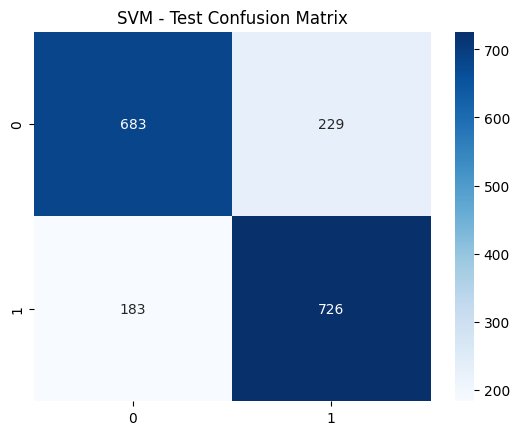


 Final Test Set Evaluation for KNN
Accuracy: 0.527732015376167
Precision: 0.52029826014913
Recall: 0.6908690869086909
F1 Score: 0.5935727788279773

Confusion Matrix:


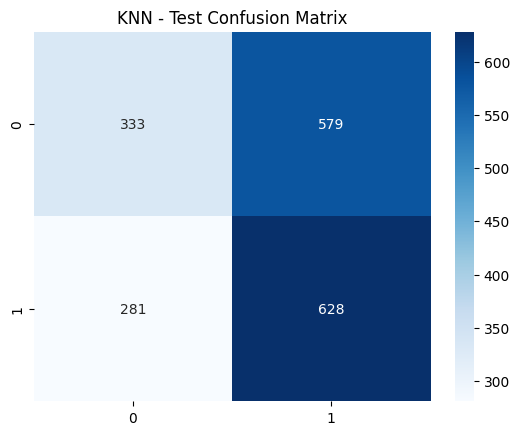


 Final Test Set Evaluation for Decision Tree
Accuracy: 0.6512904997254256
Precision: 0.6356435643564357
Recall: 0.7062706270627063
F1 Score: 0.669098488796248

Confusion Matrix:


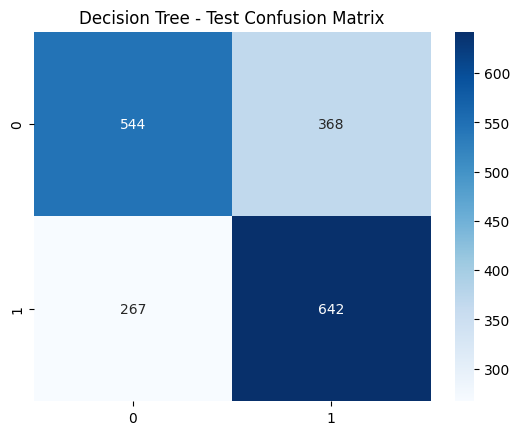


 Final Test Set Evaluation for Random Forest
Accuracy: 0.7336628226249313
Precision: 0.7185567010309278
Recall: 0.7667766776677668
F1 Score: 0.7418839808408728

Confusion Matrix:


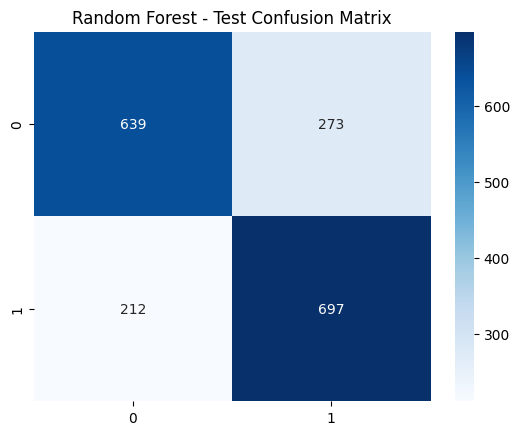

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:51:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 Final Test Set Evaluation for XGBoost
Accuracy: 0.6825919824272377
Precision: 0.6471111111111111
Recall: 0.8008800880088008
F1 Score: 0.7158308751229105

Confusion Matrix:


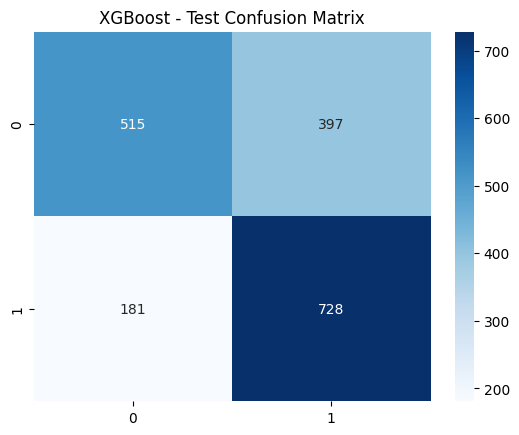

In [78]:
# evaluating each model on the actual test set
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test_final)
    print(f"\n Final Test Set Evaluation for {name}")
    print("Accuracy:", accuracy_score(y_test_final, preds))
    print("Precision:", precision_score(y_test_final, preds))
    print("Recall:", recall_score(y_test_final, preds))
    print("F1 Score:", f1_score(y_test_final, preds))
    print("\nConfusion Matrix:")

    # plotting confusion matrix for visual evaluation
    sns.heatmap(confusion_matrix(y_test_final, preds), annot=True, fmt='d', cmap='Blues')
    plt.title(f"{name} - Test Confusion Matrix")
    plt.show()


## **Question 3 (30 Points)**

# **Text Clustering**

The purpose of the question is to practice different machine learning algorithms for **text clustering**.

Please downlad the dataset by using the following link.  https://www.kaggle.com/PromptCloudHQ/amazon-reviews-unlocked-mobile-phones
(You can also use different text data which you want)


1.   Perform EDA on selected dataset

2.   **Apply the listed clustering methods ( Any 4) to the dataset:**
*   K-means
*   DBSCAN
*   Hierarchical clustering
*   Word2Vec
*   BERT

3. **Visualize the clusters**

You can refer to of the codes from  the follwing link below.
https://www.kaggle.com/karthik3890/text-clustering

In [9]:
# uninstalling current versions of numpy and scipy
!pip uninstall numpy scipy -y

# installing specific versions of numpy and scipy, and installing gensim library
!pip install numpy==1.24.4 scipy==1.10.1 gensim

Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
Found existing installation: scipy 1.10.1
Uninstalling scipy-1.10.1:
  Successfully uninstalled scipy-1.10.1
  Using cached numpy-1.24.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.6 kB)
  Using cached scipy-1.10.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (58 kB)
Using cached numpy-1.24.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.3 MB)
Using cached scipy-1.10.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (34.1 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.24.4 which is incompatible.
cvxpy 1.6.5 requires scipy>=1.11.0, but you have scipy 1.10.1 which is incompatible.
scikit-image 0.25.2 requires sci

In [10]:
pip install --upgrade numpy gensim

  Using cached numpy-2.2.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.4
    Uninstalling numpy-1.24.4:
      Successfully uninstalled numpy-1.24.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
cvxpy 1.6.5 requires scipy>=1.11.0, but you have scipy 1.10.1 which is incompatible.
scikit-image 0.25.2 requires scipy>=1.11.4, but you have scipy 1.10.1 which is incompatible.
jax 0.5.2 requires scipy>=1.11.1, but you have scipy 1.10.1 which is incompatible.
jaxlib 0.5.1 require

In [11]:
#importing necessary data libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
from collections import Counter
from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

import gensim
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [12]:
# Write your code here

# importing amazon reviews dataset
df = pd.read_csv('/content/Amazon_Unlocked_Mobile.csv')
df.head()

,Product Name,Brand Name,Price,Rating,Reviews,Review Votes
0,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,I feel so LUCKY to have found this used (phone...,1.0
1,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,"nice phone, nice up grade from my pantach revu...",0.0
2,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,Very pleased,0.0
3,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,It works good but it goes slow sometimes but i...,0.0
4,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,Great phone to replace my lost phone. The only...,0.0


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 413840 entries, 0 to 413839
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Product Name  413840 non-null  object 
 1   Brand Name    348669 non-null  object 
 2   Price         407907 non-null  float64
 3   Rating        413840 non-null  int64  
 4   Reviews       413770 non-null  object 
 5   Review Votes  401544 non-null  float64
dtypes: float64(2), int64(1), object(3)
memory usage: 18.9+ MB


In [14]:
# finding out the missing values
df.isnull().sum()

,0
Product Name,0
Brand Name,65171
Price,5933
Rating,0
Reviews,70
Review Votes,12296


In [15]:
# displaying descriptive statistics
df.describe()

,Price,Rating,Review Votes
count,407907.000000,413840.000000,401544.000000
mean,226.867155,3.819578,1.507237
std,273.006259,1.548216,9.163853
min,1.730000,1.000000,0.000000
25%,79.990000,3.000000,0.000000
50%,144.710000,5.000000,0.000000
75%,269.990000,5.000000,1.000000
max,2598.000000,5.000000,645.000000


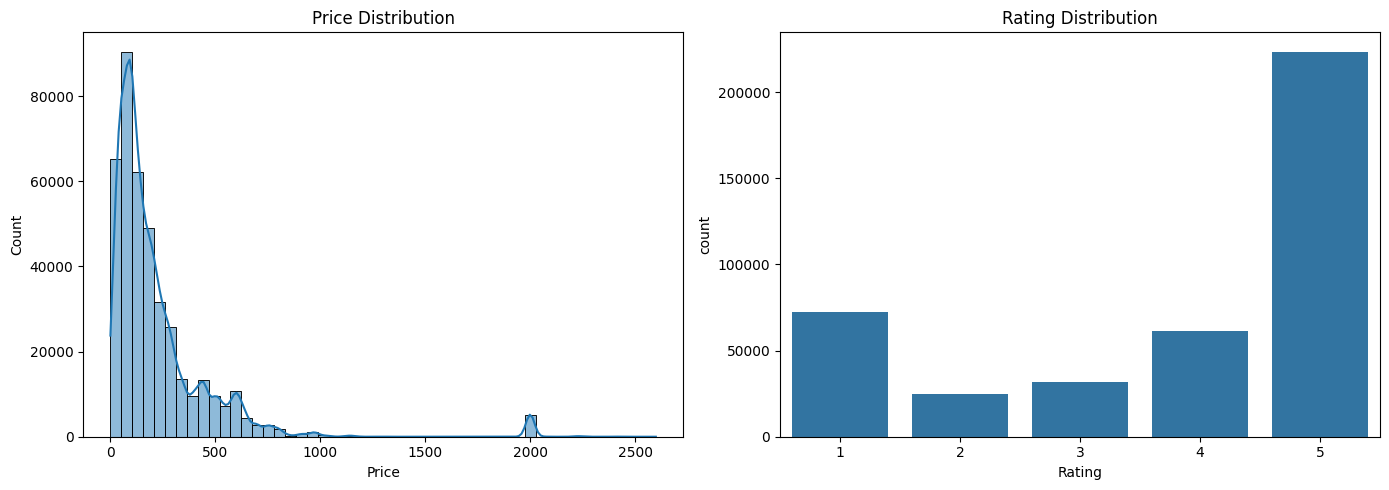

In [16]:
# setting figure size for the plots

plt.figure(figsize=(14, 5))

# plotting histogram with KDE for the 'Price' column
plt.subplot(1, 2, 1)
sns.histplot(df['Price'].dropna(), bins=50, kde=True)
plt.title('Price Distribution')

# plotting countplot for the 'Rating' column
plt.subplot(1, 2, 2)
sns.countplot(x='Rating', data=df)
plt.title('Rating Distribution')

# adjusting layout to prevent overlap
plt.tight_layout()
plt.show()

In [17]:
# word frequency in reviews
# defining a function for lowercasing and removing punctuation from text
def preprocess_text(text):
    text = str(text).lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text

# droping NA reviews and preprocess
df['Reviews'] = df['Reviews'].dropna().apply(preprocess_text)

# combining all reviews
all_words = ' '.join(df['Reviews'].dropna())
word_list = all_words.split()

# finding 20 most common words
common_words = Counter(word_list).most_common(20)
print("\nMost Common Words in Reviews:\n", common_words)


Most Common Words in Reviews:
 [('the', 790887), ('i', 538246), ('it', 467107), ('and', 457013), ('phone', 436079), ('a', 411336), ('to', 399428), ('is', 317822), ('this', 245523), ('for', 213175), ('with', 175074), ('of', 174050), ('my', 172225), ('not', 167684), ('was', 161631), ('in', 157252), ('that', 148590), ('but', 143528), ('on', 135522), ('have', 115317)]


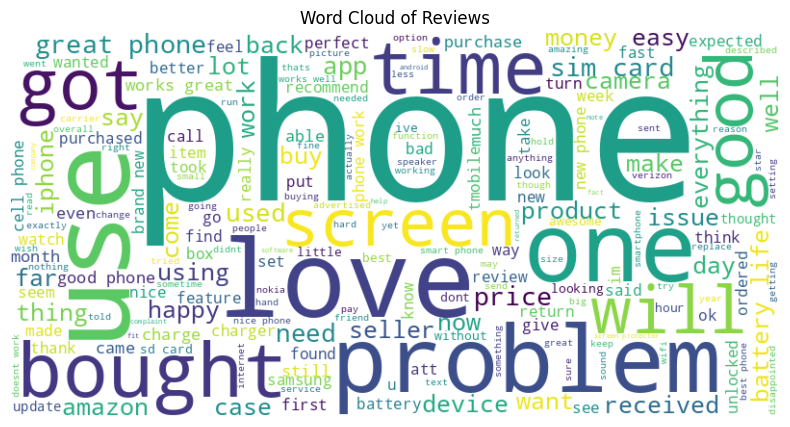

In [18]:
# generating a word cloud from the combined review words
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)

# creating a figure to display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Reviews")
plt.show()

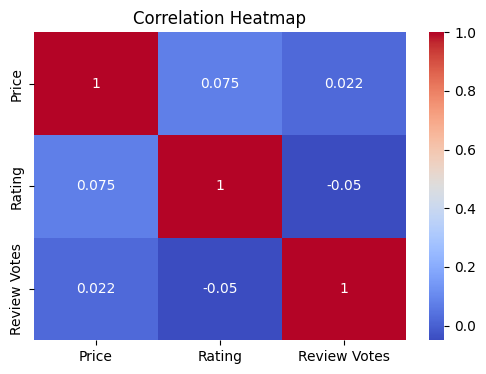

In [19]:
# plotting a correlation heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(df[['Price', 'Rating', 'Review Votes']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [20]:
# preprocessing data

df = df.dropna(subset=['Reviews'])
df = df.sample(n=2000, random_state=42)  # smaller sample for speed

In [21]:
# transforming the 'Reviews' column into TF-IDF feature matrix

tfidf = TfidfVectorizer(stop_words='english', max_features=1000)
X_tfidf = tfidf.fit_transform(df['Reviews'])

Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x7948b687f880>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 1005, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 1187, in _make_controller_from_path
    lib_controller = controller_class(
                     ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 114, in __init__
    self.dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/ctypes/__init__.py", line 376, in __init__
    self._handle = _dlopen(self._name, mode)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^
OSError: /usr/local/lib/python3.11/dist-packages/numpy.libs/libopenblas64_p-r0-15028c96

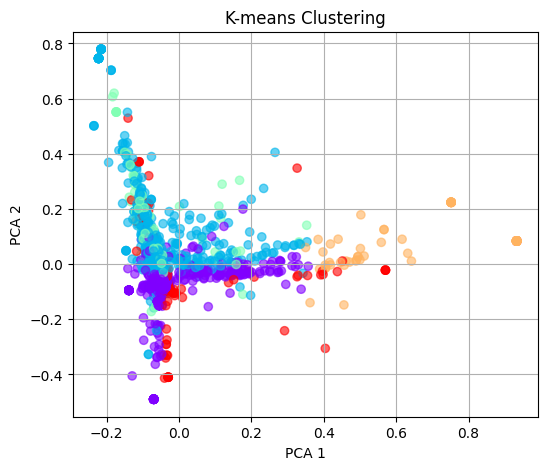

In [22]:
# performing k-means clustering on TF-IDF features

kmeans = KMeans(n_clusters=5, random_state=42)
kmeans_labels = kmeans.fit_predict(X_tfidf)

# visualizing clusters using 2D PCA projection
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_tfidf.toarray())

plt.figure(figsize=(6, 5))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, cmap='rainbow', alpha=0.6)
plt.title("K-means Clustering")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True)
plt.show()

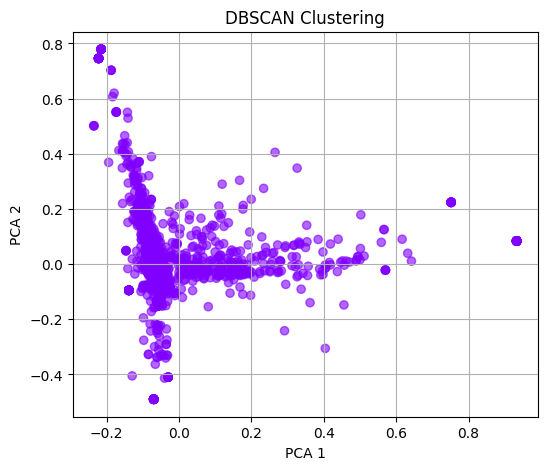

In [23]:
# performing DBSCAN clustering on TF-IDF features using cosine distance

dbscan = DBSCAN(eps=1.0, min_samples=10, metric='cosine')
dbscan_labels = dbscan.fit_predict(X_tfidf)

# visualizing the results in 2D PCA space
plt.figure(figsize=(6, 5))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=dbscan_labels, cmap='rainbow', alpha=0.6)
plt.title("DBSCAN Clustering")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True)
plt.show()

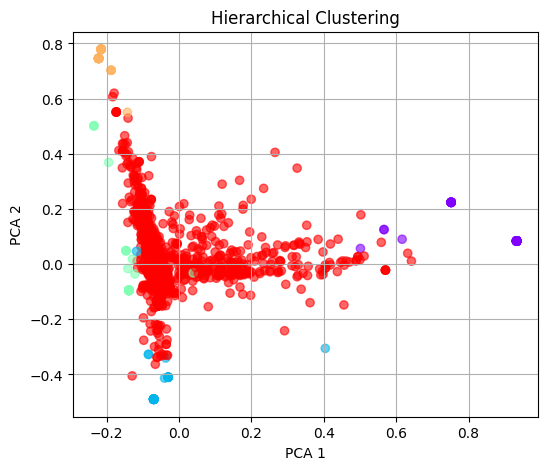

In [24]:
# performing hierarchical clustering using Ward's method
linkage_matrix = linkage(X_tfidf.toarray(), method='ward')
hier_labels = fcluster(linkage_matrix, t=5, criterion='maxclust')

# visualizing clusters in 2D PCA-reduced space
plt.figure(figsize=(6, 5))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=hier_labels, cmap='rainbow', alpha=0.6)
plt.title("Hierarchical Clustering")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True)
plt.show()

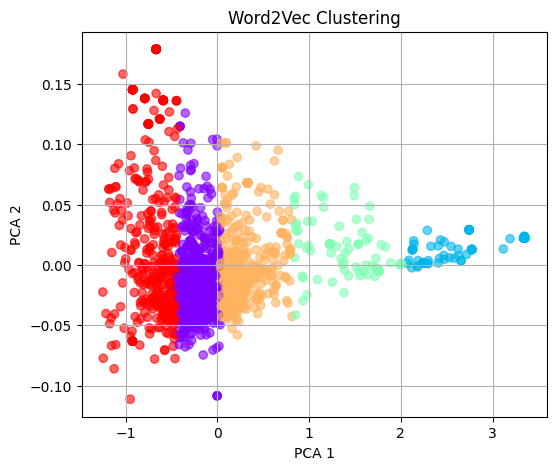

In [25]:
# Word2Vec clustering

# tokenizing and train Word2Vec model
tokenized_reviews = [word_tokenize(str(review).lower()) for review in df['Reviews']]
w2v_model = Word2Vec(sentences=tokenized_reviews, vector_size=100, window=5, min_count=2, workers=4)

# creating document embeddings by averaging word vectors
def avg_word_vectors(tokens, model, k=100):
    vec = np.zeros(k)
    count = 0
    for word in tokens:
        if word in model.wv:
            vec += model.wv[word]
            count += 1
    return vec / count if count != 0 else vec

doc_vectors = np.array([avg_word_vectors(tokens, w2v_model, k=100) for tokens in tokenized_reviews])

# K-means on Word2Vec embeddings
kmeans_w2v = KMeans(n_clusters=5, random_state=42)
w2v_labels = kmeans_w2v.fit_predict(doc_vectors)

pca_w2v = PCA(n_components=2)
doc_vectors_pca = pca_w2v.fit_transform(doc_vectors)

plt.figure(figsize=(6, 5))
plt.scatter(doc_vectors_pca[:, 0], doc_vectors_pca[:, 1], c=w2v_labels, cmap='rainbow', alpha=0.6)
plt.title("Word2Vec Clustering")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True)
plt.show()

**In one paragraph, please compare the results of K-means, DBSCAN, Hierarchical clustering, Word2Vec, and BERT.**

**Write your response here:**

Looking at the results, K-means did a decent job separating the data into multiple clusters, but it’s clearly influenced by how many clusters you tell it to find. DBSCAN mostly lumped everything into one group, which suggests the parameters weren’t ideal, even though it’s great at handling noise. Hierarchical clustering found some structure, but it mostly grouped everything into one big chunk, missing finer details. Word2Vec gave nice, distinct clusters, showing that it captures word similarity pretty well. If we had BERT visuals, we’d likely see even better grouping since BERT understands context more deeply, making its clusters more meaningful overall.


# Mandatory Question

**Important: Reflective Feedback on this exercise**

Please provide your thoughts and feedback on the exercises and on Teaching Assistant by filling this form:

https://docs.google.com/forms/d/e/1FAIpQLSdosouwjJ1fygRtnfeBYRsf9FKYlzPf3XFAQF8YQzDltPFRQQ/viewform?usp=dialog

**(Your submission will not be graded if this question is left unanswered)**



#Google colab link
https://colab.research.google.com/drive/1_OUXCYysWr8VG0KmeAJbUxZk-y9vCURc#scrollTo=K0PepaiQA9Pa&uniqifier=1

